Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 ship horse  ship   dog


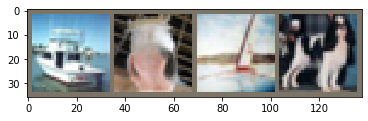

In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from models.VGG16_with_flex_v10 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

19,241,246 total parameters.
19,241,246 trainable parameters.


In [3]:
model

VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): FlexiLayer1(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (7): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): FlexiLayer2(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): Dropout2d(p=0.4, inplace=False)
  )
 

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  model.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = model(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 200  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
  model.train(True)
  epoch_loss  = 0
  i_count = 0
  acc_total = 0
  for i,(images,labels) in enumerate(trainloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    labels = Variable(labels)
    optimizer.zero_grad()
    outputs = model(Variable(images))
    loss = criterion(outputs,labels)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    _,predicted = outputs.max(1)
    denom = labels.size(0)
    correct = predicted.eq(labels).sum().item()
    acc = 100*(correct/denom)
    acc_total += acc
    i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
  schedule.step()
  train_loss.append(epoch_loss)
  print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
  print('\n')
  test_acc = test()      # Print the test accuracy per epoch
  test_accuracy.append(test_acc)
  
  if(epoch%50 == 0):       # Save the model every 50 epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './models/VGG16-flex-v10-Maxpools-' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


Epoch:  0   Loss:  1095.6112341880798   Train Accuracy : 16.246


Test accuracy: 12 %
Epoch:  1   Loss:  993.1688697338104   Train Accuracy : 21.75


Test accuracy: 18 %
Epoch:  2   Loss:  936.6700639724731   Train Accuracy : 26.97


Test accuracy: 25 %
Epoch:  3   Loss:  890.0105053186417   Train Accuracy : 31.114


Test accuracy: 29 %
Epoch:  4   Loss:  855.8779919147491   Train Accuracy : 34.192


Test accuracy: 35 %
Epoch:  5   Loss:  824.8954125642776   Train Accuracy : 37.518


Test accuracy: 38 %
Epoch:  6   Loss:  796.7768676280975   Train Accuracy : 40.13


Test accuracy: 40 %
Epoch:  7   Loss:  768.2594484090805   Train Accuracy : 42.904


Test accuracy: 45 %
Epoch:  8   Loss:  741.8495017290115   Train Accuracy : 44.806


Test accuracy: 46 %
Epoch:  9   Loss:  714.3723510503769   Train Accuracy : 47.698


Test accuracy: 54 %
Epoch:  10   Loss:  685.071456193924   Train Accuracy : 51.028


Test accuracy: 55 %
Epoch:  11   Loss:  659.7954469919205   Train Accuracy : 53.726


T

Test accuracy: 88 %
Epoch:  96   Loss:  156.03850202262402   Train Accuracy : 93.32


Test accuracy: 88 %
Epoch:  97   Loss:  153.50333127379417   Train Accuracy : 93.462


Test accuracy: 87 %
Epoch:  98   Loss:  154.8093753606081   Train Accuracy : 93.344


Test accuracy: 88 %
Epoch:  99   Loss:  154.92706130445004   Train Accuracy : 93.388


Test accuracy: 88 %
Epoch:  100   Loss:  143.56019409000874   Train Accuracy : 94.24


Test accuracy: 88 %
Epoch:  101   Loss:  137.45578737556934   Train Accuracy : 94.448


Test accuracy: 88 %
Epoch:  102   Loss:  138.1751198619604   Train Accuracy : 94.502


Test accuracy: 88 %
Epoch:  103   Loss:  135.3607683032751   Train Accuracy : 94.52


Test accuracy: 88 %
Epoch:  104   Loss:  132.98166920244694   Train Accuracy : 94.8


Test accuracy: 88 %
Epoch:  105   Loss:  129.85061252117157   Train Accuracy : 94.924


Test accuracy: 88 %
Epoch:  106   Loss:  128.6549230515957   Train Accuracy : 95.092


Test accuracy: 88 %
Epoch:  107   Loss:  127.

Test accuracy: 89 %
Epoch:  191   Loss:  63.70243597775698   Train Accuracy : 98.84


Test accuracy: 89 %
Epoch:  192   Loss:  63.26682072877884   Train Accuracy : 98.92


Test accuracy: 89 %
Epoch:  193   Loss:  63.79350396990776   Train Accuracy : 98.804


Test accuracy: 89 %
Epoch:  194   Loss:  63.200417436659336   Train Accuracy : 98.888


Test accuracy: 89 %
Epoch:  195   Loss:  64.05184936523438   Train Accuracy : 98.82


Test accuracy: 89 %
Epoch:  196   Loss:  63.216602467000484   Train Accuracy : 98.896


Test accuracy: 89 %
Epoch:  197   Loss:  60.856789872050285   Train Accuracy : 98.932


Test accuracy: 89 %
Epoch:  198   Loss:  62.414130970835686   Train Accuracy : 98.942


Test accuracy: 89 %
Epoch:  199   Loss:  61.997017215937376   Train Accuracy : 98.914


Test accuracy: 89 %
Epoch:  200   Loss:  61.143398985266685   Train Accuracy : 98.972


Test accuracy: 89 %


In [5]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 89 %
89.87
Accuracy of plane : 97 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 74 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 98 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %


In [6]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', test_accuracy]:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>